In [ ]:
import zipfile
!rm /content/download
!rm -r /content/imagedb/
!rm -r /content/imagedb_test
!wget https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
local_zip = '/content/download'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

train_dir = '/content/imagedb'
test_dir = '/content/imagedb_test'


rm: cannot remove '/content/download': No such file or directory
rm: cannot remove '/content/imagedb/': No such file or directory
rm: cannot remove '/content/imagedb_test': No such file or directory
--2023-01-27 13:47:54--  https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181682323 (173M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 173.27M  4.98MB/s    in 23s     

2023-01-27 13:48:16 (7.69 MB/s) - ‘download’ saved [181682323/181682323]



In [ ]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers

# Initialize a sequential model
model = models.Sequential()

# Add convolutional layers and max pooling layers to the model
# Each convolutional layer is followed by batch normalization for stable training
# The network structure aims to reduce dimensions while increasing depth

# First convolutional layer with stride 2 for downsampling, reducing height and width by half
model.add(layers.Conv2D(16, kernel_size=(3, 3), strides=(2, 2),
                 activation='relu',
                 input_shape=(256, 256, 3)))  # Input shape for color images of size 256x256
model.add(layers.BatchNormalization())

# Second convolutional layer followed by max pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())

# Third convolutional layer followed by max pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.BatchNormalization())

# Fourth convolutional layer followed by max pooling
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output of the last pooling layer to feed it into a dense layer
model.add(layers.Flatten())

# Dense layer with 512 units and ReLU activation
model.add(layers.Dense(512, activation='relu'))

# Dropout layer for regularization to prevent overfitting
model.add(layers.Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(layers.Dense(34, activation='softmax'))

# Compile the model specifying the loss function, optimizer, and metrics to evaluate
model.compile(loss='categorical_crossentropy',  # Loss function for multi-class classification
              optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),  # Adam optimizer with a learning rate of 1e-4
              metrics=['acc'])  # Accuracy metric for evaluation

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
# import cv2

# def myblur(img):
#     ksize = (10, 10)
#     blur = cv2.blur(img, ksize)
#     return blur

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator for training data with data augmentation parameters
train_datagen = ImageDataGenerator(shear_range=30,  # Shear intensity (shear angle in degrees)
                                   rotation_range=15,  # Degree range for random rotations
                                   zoom_range=0.1,  # Range for random zoom
                                   brightness_range=[0.1, 1],  # Range for picking a brightness shift value
                                   validation_split=0.2)  # Fraction of images reserved for validation

# Create a train data generator that fetches images from the directory, applies data augmentation,
# and returns batches of images with their labels
train_generator = train_datagen.flow_from_directory(train_dir,  # Directory with training images
                                                    batch_size=100,  # Size of the batches of data
                                                    class_mode='categorical',  # Because we have more than two classes
                                                    target_size=(256, 256),  # Resize target to match model's expected input size
                                                    shuffle=True)  # Shuffle the data for randomness

# Create a validation data generator for evaluating the model, using the same
# ImageDataGenerator but with the 'validation' subset specified
validation_generator = train_datagen.flow_from_directory(train_dir,  # Directory with training images
                                                         batch_size=100,  # Size of the batches of data
                                                         class_mode='categorical',  # Because we have more than two classes
                                                         target_size=(256, 256),  # Resize target to match model's expected input size
                                                         subset='validation',  # Specify that this is the validation subset
                                                         seed=1)  # Seed for reproducibility


Found 3056 images belonging to 34 classes.
Found 599 images belonging to 34 classes.


In [ ]:
# Train the model
import datetime
import tensorflow as tf

# Initialize a list to hold callbacks
callbacks = []

# Create a ModelCheckpoint callback to save the best model weights during training
save_best_callback = tf.keras.callbacks.ModelCheckpoint('best_weights.hdf5', save_best_only=True, verbose=1)
callbacks.append(save_best_callback)

# Create an EarlyStopping callback to halt training when validation loss stops improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback)

# Start model training
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples / train_generator.batch_size,  # Number of steps per epoch
                    epochs=50,  # Total number of epochs to run the training
                    validation_data=validation_generator,  # Validation data to evaluate the model
                    validation_steps=validation_generator.samples / validation_generator.batch_size,  # Number of validation steps
                    verbose=1,  # Show detailed progress
                    callbacks=callbacks)  # Apply the callbacks during training


Epoch 1/50
31/30 [==============================] - ETA: 0s - loss: 2.5888 - acc: 0.3442
Epoch 1: val_loss improved from inf to 2.73675, saving model to best_weights.hdf5
30/30 [==============================] - 63s 2s/step - loss: 2.5888 - acc: 0.3442 - val_loss: 2.7367 - val_acc: 0.4491
Epoch 2/50
31/30 [==============================] - ETA: 0s - loss: 1.4353 - acc: 0.5962
Epoch 2: val_loss improved from 2.73675 to 2.02462, saving model to best_weights.hdf5
30/30 [==============================] - 51s 2s/step - loss: 1.4353 - acc: 0.5962 - val_loss: 2.0246 - val_acc: 0.7679
Epoch 3/50
31/30 [==============================] - ETA: 0s - loss: 0.9968 - acc: 0.7075
Epoch 3: val_loss improved from 2.02462 to 1.42099, saving model to best_weights.hdf5
30/30 [==============================] - 50s 2s/step - loss: 0.9968 - acc: 0.7075 - val_loss: 1.4210 - val_acc: 0.7963
Epoch 4/50
31/30 [==============================] - ETA: 0s - loss: 0.7603 - acc: 0.7762
Epoch 4: val_loss improved from 1

In [ ]:
test_datagen  = ImageDataGenerator()
# --------------------
# Flow validation images in batches of 100 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=100,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(256,256))
loss, acc = model.evaluate(test_generator)

Found 2149 images belonging to 34 classes.
22/22 [==============================] - 3s 116ms/step - loss: 0.1499 - acc: 0.9800


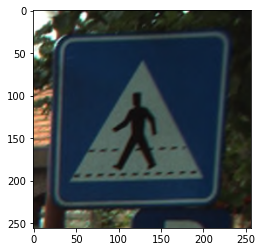

1/1 [==============================] - 0s 213ms/step



['00004', '00005', '00007', '00008', '00010', '00012', '00013', '00017', '00018', '00019', '00021', '00027', '00028', '00029', '00030', '00031', '00032', '00034', '00035', '00037', '00038', '00039', '00041', '00042', '00043', '00045', '00047', '00051', '00053', '00054', '00056', '00057', '00058', '00059']



Softmax Output: [[2.9796654e-17 5.1302706e-15 1.8476709e-15 2.5263435e-15 3.8706800e-14
  1.6754450e-15 6.0042121e-15 1.8835749e-14 2.5156602e-14 4.6803275e-17
  4.2570698e-16 2.9320395e-16 4.5652556e-15 1.3890376e-19 1.5229052e-15
  6.7814252e-17 1.3627574e-13 1.3120597e-16 1.0396688e-15 3.1446325e-14
  9.1286042e-14 1.3784675e-15 1.2181138e-15 1.2479125e-18 2.2412665e-15
  1.4278980e-14 7.3495348e-14 2.9129523e-13 3.5521443e-11 2.7428626e-12
  9.9999988e-01 1.3183923e-07 4.3060516e-16 7.7959632e-11]]



/content/imagedb_test/00056/00125_00000.ppm is a 00056





In [ ]:
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

path = '/content/imagedb_test/00056/00125_00000.ppm'
img = load_img(path, target_size=(256, 256), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

model = tf.keras.models.load_model('/content/best_weights.hdf5')
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

classes_pred = model.predict(x)
classes = ['00004', '00005', '00007', '00008', '00010', '00012', '00013', '00017', '00018', '00019', '00021', '00027', '00028'
            , '00029', '00030', '00031', '00032', '00034', '00035', '00037', '00038', '00039', '00041', '00042', '00043', '00045'
            , '00047', '00051', '00053', '00054', '00056', '00057', '00058', '00059']
print(f'\n\n\n{classes}')
print(f'\n\n\nSoftmax Output: {classes_pred}')
print(f'\n\n\n{path} is a {classes[classes_pred.argmax()]}\n\n\n')